In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import warnings
import plotly.graph_objects as go

df = pd.read_csv('eia_monthly_data.csv')
df['period'] = pd.to_datetime(df['period'])
df.set_index('period', inplace=True)
df.sort_index(inplace=True)

nuclear_df = df[df['fuelTypeDescription'] == 'nuclear'].copy()
print(nuclear_df.head())

           fueltypeid fuelTypeDescription  consumption-for-eg-btu  \
period                                                              
2001-01-01        NUC             nuclear                  37.020   
2001-02-01        NUC             nuclear                  31.719   
2001-03-01        NUC             nuclear                  25.717   
2001-04-01        NUC             nuclear                  27.868   
2001-05-01        NUC             nuclear                  35.710   

            consumption-uto-btu  cost-per-btu  generation  heat-content  \
period                                                                    
2001-01-01                  0.0           NaN    3545.310           NaN   
2001-02-01                  0.0           NaN    3037.626           NaN   
2001-03-01                  0.0           NaN    2462.837           NaN   
2001-04-01                  0.0           NaN    2668.816           NaN   
2001-05-01                  0.0           NaN    3419.870         

In [28]:

def model_seasonal_avg(train_data, horizon):

    monthly_avgs = train_data.groupby(train_data.index.month).mean()
    
    last_date = train_data.index[-1]
    forecast_dates = pd.date_range(
        start=last_date + pd.DateOffset(months=1), 
        periods=horizon, 
        freq='MS'
    )
    
    forecast_values = []
    for date in forecast_dates:
        month = date.month
        if month in monthly_avgs.index:
            forecast_values.append(monthly_avgs.loc[month])
        else:
            forecast_values.append(train_data.mean())
            
    return pd.Series(forecast_values, index=forecast_dates)

def run_backtest(series, model_function, train_window, horizon, step):

    results = []
    total_len = len(series)
    start_idx = 0
    
    
    while True:
        end_train_idx = start_idx + train_window
        
        if end_train_idx >= total_len:
            break
            
        train_series = series.iloc[start_idx : end_train_idx]
        
        forecast_series = model_function(train_series, horizon)
        start_idx += step

        results.append({
            'cutoff_date': train_series.index[-1],
            'forecast': forecast_series,
            'actuals': series
        })
        
    return results


def evaluate_and_plot(ax, sector_name, results):
    if not results:
        return 0

    actual_series = results[0]['actuals']
    ax.plot(actual_series.index.to_numpy(), actual_series.to_numpy(), color='green', linewidth=2, label='Actual Data', zorder=1)
    
    errors = []
    
    first_fc = True
    for item in results:
        fc = item['forecast']
        cutoff = item['cutoff_date']
        
        common_idx = fc.index.intersection(actual_series.index)
        if not common_idx.empty:
            rmse = np.sqrt(mean_squared_error(actual_series[common_idx], fc[common_idx]))
            errors.append(rmse)
        
        label = 'Rolling Forecast' if first_fc else None
        ax.plot(fc.index.to_numpy(), fc.to_numpy(), color='red', linestyle='--', alpha=0.7, label=label, zorder=2)
        
        if cutoff in actual_series.index:
             ax.scatter(cutoff, actual_series[cutoff], color='black', s=20, zorder=3)
        first_fc = False

    avg_rmse = np.mean(errors) if errors else 0
    
    ax.set_title(f"{sector_name} | Avg RMSE: {avg_rmse:,.0f}")
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    
    return avg_rmse

def get_prediction_diffs(results_list, sector_name):

    all_dfs = []
    
    if not results_list:
        return None
    
    for res in results_list:
        cutoff = res['cutoff_date']
        fc = res['forecast']
        actuals = res['actuals']
        
        common_idx = fc.index.intersection(actuals.index)
        
        if common_idx.empty:
            continue
            
        diffs = fc[common_idx] - actuals[common_idx]
        
        window_df = pd.DataFrame({
            'Sector': sector_name,
            'Cutoff_Date': cutoff,
            'Prediction_Date': common_idx,
            'Predicted': fc[common_idx],
            'Actual': actuals[common_idx],
            'Error_Diff': diffs,
            'Abs_Error': diffs.abs()
        })
        all_dfs.append(window_df)
            
    return pd.concat(all_dfs, ignore_index=True) if all_dfs else pd.DataFrame()

In [29]:

CHOSEN_MODEL = model_seasonal_avg
TRAIN_WINDOW = 120 # 10 years
FORECAST_HORIZON = 36
STEP_SIZE = 36

series = nuclear_df['generation'].dropna()

results = run_backtest(
    series, 
    CHOSEN_MODEL, 
    TRAIN_WINDOW, 
    FORECAST_HORIZON, 
    STEP_SIZE
)





In [30]:
all_errors_df = get_prediction_diffs(results, 'Nuclear')


   > Nuclear Average RMSE: 330.43


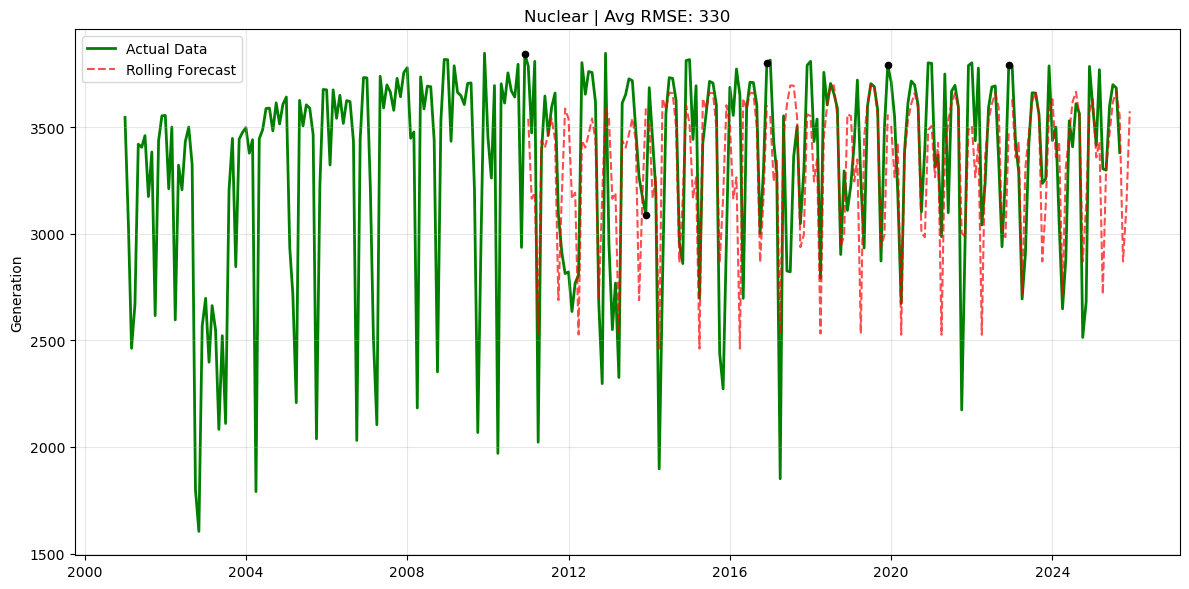

In [31]:
# Plot
fig, ax = plt.subplots(figsize=(12, 6))
rmse = evaluate_and_plot(ax, "Nuclear", results)
ax.set_ylabel("Generation")
plt.tight_layout()
plt.savefig('nuclear_forecast.png')

print(f"   > Nuclear Average RMSE: {rmse:,.2f}")

In [32]:
all_errors_df


,Sector,Cutoff_Date,Prediction_Date,Predicted,Actual,Error_Diff,Abs_Error
0,Nuclear,2010-12-01,2011-01-01,3538.9102,3786.420,-247.5098,247.5098
1,Nuclear,2010-12-01,2011-02-01,3164.1037,3472.886,-308.7823,308.7823
2,Nuclear,2010-12-01,2011-03-01,3192.4555,3808.335,-615.8795,615.8795
3,Nuclear,2010-12-01,2011-04-01,2527.4128,2022.377,505.0358,505.0358
4,Nuclear,2010-12-01,2011-05-01,3436.9380,3380.340,56.5980,56.5980
...,...,...,...,...,...,...,...
172,Nuclear,2022-12-01,2025-05-01,3312.6476,3298.128,14.5196,14.5196
173,Nuclear,2022-12-01,2025-06-01,3470.4251,3599.212,-128.7869,128.7869
174,Nuclear,2022-12-01,2025-07-01,3618.6134,3699.006,-80.3926,80.3926
175,Nuclear,2022-12-01,2025-08-01,3665.4943,3683.574,-18.0797,18.0797


In [33]:
import plotly.graph_objects as go
import pandas as pd

def plot_split_errors_plotly(all_errors_df):


    sectors = all_errors_df['Sector'].unique()


    for sector in sectors:
        sector_data = all_errors_df[all_errors_df['Sector'] == sector]
        cutoffs = sorted(sector_data['Cutoff_Date'].unique())
        
        if len(cutoffs) == 0:
            continue
            

        # 1. Plot each Cutoff as an Independent Figure
        for i, cutoff in enumerate(cutoffs):
            
            group = sector_data[sector_data['Cutoff_Date'] == cutoff]
            
            fig = go.Figure()
            
            fig.add_trace(
                go.Scatter(
                    x=group['Prediction_Date'], 
                    y=group['Error_Diff'],
                    mode='lines+markers',
                    marker=dict(size=6),
                    line=dict(color='#d62728', width=2),
                    name=f"Run {str(cutoff)[:10]}",
                    hovertemplate="<b>Date</b>: %{x}<br><b>Error</b>: %{y:,.2f}<extra></extra>"
                )
            )
            
            # Add Zero Reference Line
            fig.add_hline(
                y=0, 
                line_dash="dash", 
                line_color="black", 
                line_width=1, 
                opacity=0.5
            )

            # Final Layout Adjustments
            cutoff_str = pd.to_datetime(cutoff).strftime('%Y-%m-%d')
            fig.update_layout(
                title_text=f"{sector} Prediction Error | Run: {cutoff_str}",
                title_x=0.5,
                xaxis_title="Prediction Date",
                yaxis_title="Error (Predicted - Actual)",
                template="plotly_white",
                hovermode="x",
                height=400, # Standard height for single plot
                width=1000  # Wide format
            )
            
            fig.show()
        
        print("-" * 80)

In [34]:
plot_split_errors_plotly(all_errors_df)

--------------------------------------------------------------------------------
